# Process the data files into the final format that we will use for the experiment

##### IMPORTS

In [1]:
from functions import * 
from IPython.display import clear_output
import os

Welcome to JupyROOT 6.24/00


##### GLOBAL VARIABLES 
may need to set as input for certain functions:

In [2]:
# Get a handle for the record_path
record_path = '../Scripts&Records/'

##### FUNCTION DEFINITIONS:

In [3]:
def progress_bar(id_,array_):
    # Progress Bar
    clear_output(wait=True)
    print(f"Processing file {id_+1} of {len(array_)} files... {round(100*(id_+1)/len(array_),2)}% Complete")
    return


def status_update_msg(msg):
    clear_output(wait=True)
    print(msg)
    return

##### DATA PREPARATION:

In [4]:
# Initialize lists of dataframes, one per stream type
df_express_list, df_pMain_list = [],[]

# Initialize path of data replica folders
path = '../'

# Loop through data replica folders
for idF,file in enumerate(os.listdir(path)):
    
    # Progress Bar
    clear_output(wait=True)
    print(f"Processing file {idF+1} of {len(os.listdir(path))} files... {round(100*(idF+1)/len(os.listdir(path)),2)}% Complete")
    
    # Skip irrelevant folders
    if file == "Scripts&Records":
        continue
    
    # Loop through data replica files inside folder
    for file2 in os.listdir(path+file):
        
        # Process data to dataframe and append to list of dataframes, some are express stream some are pMain stream, 2 separate df_lists will reduce memory vs adding columns
        if 'express_express' in file2:
            df_express_list.append(hist_to_df(path+file+'/'+file2))
        else:
            df_pMain_list.append(hist_to_df(path+file+'/'+file2))

Processing file 29 of 29 files... 100.0% Complete


##### Check to see if the number of entries is the same between the express and pMain streams for each run:

In [5]:
# Loop through the number of express or pMain data files
for i in range(14):
    # Check to see if the express dataframe that is associated with the pMain dataframe are of the same size
    print(i,df_express_list[i].shape[0] == df_pMain_list[i].shape[0])

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True


##### SAWYER NOTE: 
According to the above, run 348251, the pMain and express streams do not have the same number of entries -- ask sawyer if this is a problem 
<br>
if it is, then skip them when concatenating the dataframes below using something like the following:

##### Compiling the databases takes too much memory to hold 2*(N) dataframes between the 2 lists then compile the databases, doubling memory requirements, store each to its own csv then concat one at a time:

In [24]:
# Loop through the pMain dataframe list 
for idN,df in enumerate(df_express_list):
    
    #Construct the run string from the list of express dataframes
    run_string = df['paths'].values[0].split('/')[0]
    
    # Send the processed pMain df.csv to the appropriate folder with the appropriate name
    df.to_csv('../unprocessed_dfs_express/express_data_files_'+run_string+'.csv')
    
# Loop through the pMain dataframe list
for idN,df in enumerate(df_pMain_list):
    
    #Construct the run string from the list of pMain dataframes
    run_string = df['paths'].values[0].split('/')[0]
    
    # Send the processed pMain df.csv to the appropriate folder with the appropriate name
    df.to_csv('../unprocessed_dfs_pMain/pMain_data_files_'+run_string+'.csv')
    
# Free up the memory
del df_express_list
del df_pMain_list
del run_string

##### Compile each list to one database each, one for express stream, one for pMain stream:

In [14]:
status_update_msg("Initializing Processing for express...")


# Get a handle for the location of the express csv files
data_path = '../unprocessed_dfs_express/'


# Determine if express_db_df exists, initialize or append to the database accordingly
if 'express_db_df.csv' in os.listdir(record_path):
    express_db_df = pd.read_csv(record_path +'express_db_df.csv',,index_col=[0])
else:
    express_db_df = pd.DataFrame()

    
# Loop through the files in the data_path, process them, and append them    
for idF,express_file in enumerate(os.listdir(data_path)):
    
    # Progress Bar
    progress_bar(idF,os.listdir(data_path))
    
    # Processing dataframe and compiling dataframe_database
    df = pd.read_csv(data_path+express_file,index_col=[0])
    express_db_df = pd.concat([express_db_df,df])


# Free up memeory from this file
del express_file

    
# Reduce df.memory_usage() by converting paths column to category datatype - these 14 datasets nearly max out the entire 8gb of ram
status_update_msg("Converting express path column to category datatype...")
express_db_df['paths'] = express_db_df['paths'].astype('category')


# Save database as csv (56,064,638 datapoints took 7m15s for this part of the code alone..thats 6.36GB file size according to the directory viewer)
status_update_msg("Saving express_db_df datafarme to csv(this could take several minutes+)...")
express_db_df.to_csv('express_db_df.csv')
del df
del express_db_df


# Notify that Express Database Processing is Complete
status_update_msg("Express Database Processing Complete.")


status_update_msg("Initializing Processing for pMain...")


# Get a handle for the location of the pMAin csv files
data_path = '../unprocessed_dfs_pMain/'


# Determine if pMain_db_df exists, initialize or append to the database accordingly
if 'pMain_db_df.csv' in os.listdir(record_path):
    pMain_db_df = pd.read_csv(record_path+'pMain_db_df.csv',index_col=[0])
else:
    pMain_db_df = pd.DataFrame()

    
# Loop through the files in the data_path, process them, and append them    
for idF,pMain_file in enumerate(os.listdir(data_path)):
    
    # Progress Bar
    progress_bar(idF,os.listdir(data_path))
    
    # Processing dataframe and compiling dataframe_database
    df = pd.read_csv(data_path+pMain_file,index_col=[0])
    pMain_db_df = pd.concat([pMain_db_df,df])
    

# Free up memeory from this file
del pMain_file
    
# Reduce df.memory_usage() by converting paths column to category datatype - these 14 datasets nearly max out the entire 8gb of ram
status_update_msg("Converting pMain path column to category datatype...")
pMain_db_df['paths'] = pMain_db_df['paths'].astype('category')


# Save database as csv (56,064,638 datapoints took 7m15s for this part of the code alone..thats 6.36GB file size according to the directory viewer)
status_update_msg("Saving pMain_db_df dataframe to csv(this could take several minutes+)...")
pMain_db_df.to_csv('pMain_db_df.csv')
del df
del pMain_db_df


# Notify that pMain DatabASEProcessing is Complete
status_update_msg("pMain Database Processing Complete.")


# Notify that Processing is Complete
status_update_msg("Processing Complete.")

Processing Complete.


##### Issues:
- The number of datapoints for 14 express stream run files is about 56,000,000. The filesize is about 6.36GB in csv format. The memory_usage according to pandas is over "2.1GB+", which could very well be the 6.36GB the csv file says - very little memory is available following holding this on an 8GB system.
- This large amount of ram for only 14 datasets is problematic for a low memory system. If we used only one type of histogram from each run just to establish a control and see how the CNN performed, it would GREATLY reduce the amount of datapoints we have per run file (to something like 98*64(depending on the histogram of interest) per histogram). Then we could get as many as 1000 run files (~ 6.2million datapoints with the original assumptions). We could also just see how these 14 datasets(~ 88000 datapoints) performed on classification
- adding the 'quality' column for 56million+ datapoints will further increase the memory required to hold this thing. Possibly construct this after getting the subset of data of interest.

##### Next Actions(Data Processing):
- select a histogram(we will use a 2d histogram)
- load the express_db_df from csv and grab only the subset of that data which is the 2d histogram selected
- do the same for pMain_db_df

In [63]:
# express PROCESSING STEP

# Read the express database into memory
status_update_msg('Reading express database...')
express_db_df = pd.read_csv(record_path+'express_db_df.csv',index_col=[0])


# Get a subset of the express database as express_hist20
status_update_msg('Getting the subset of express database...')
express_hist20 = express_db_df[express_db_df['paths'].str.contains('CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1')]


# Free up memory from the express database
del express_db_df


# Save the express_hist20.csv
status_update_msg('Saving express_hist20.csv...')
express_hist20.to_csv(record_path+'express_hist20.csv')


# pMain PROCESSING STEP


# Read the pMain database into memory
status_update_msg('Reading pMain database...')
pMain_db_df = pd.read_csv(record_path+'pMain_db_df.csv',index_col=[0])


# Get a subset of the pMain database as pMain_hist20
status_update_msg('Getting the subset of pMain database...')
pMain_hist20 = pMain_db_df[pMain_db_df['paths'].str.contains('CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1')]


# Free up memory from the pMain database
del pMain_db_df


# Save the oMain_hist20.csv
status_update_msg('Saving pMain_hist20.csv...')
pMain_hist20.to_csv(record_path+'pMain_hist20.csv')


# Notify that Processing is Complete
status_update_msg('Processing Complete.')

Processing Complete.


##### Next Actions(Data Processing):
- add the 'quality' column to express_db_df_subset as a column of all 0s (for bad)
- add the 'quality' column to pMain_db_df_subset as a column of all 1s (for good)
- do final cleaning and optimizing of datasets
- show an example preparation of the final matrices

In [4]:
# for idx,val in enumerate(tmp['quality'].values):
#     if tmp.iloc[idx,1] == x_hitcoord and tmp.iloc[idx,2] == y_hitcoord:
#         tmp.iloc[idx,4] = 1 #hit or quality class (1 or 2)

In [5]:
# hist_index = 0
# for idx,val in enumerate(tmp.iloc[:,0]):
#     if tmp.iloc[idx,0] == tmp[tmp['paths']==tmp['paths'].unique()[hist_index]]['paths'].values[0]:
#         tmp = 
#         for idxx,vall in enumerate(tmp.iloc[:,])

##### Construct functions to prepare the binary mask

In [9]:
ls ../hist_targets_txt_files/

run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt


In [18]:
path = '../hist_targets_txt_files/'
list_ = []
for file in os.listdir(path):
    pass
print(file)

run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt


In [4]:
express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])

In [5]:
express_hist20.shape

(90090, 5)

In [6]:
pMain_hist20.shape

(90090, 5)

Add the initializations to the express/pMain_hist20 databases, then save it

In [28]:
# Get a handle for express_hist20 and drop the index column
express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
# IMPORTANT: Do this line only if the previous line reads the df and the df shows a column[0] that shouldnt be there
# express_hist20 = express_hist20.drop(columns=express_hist20.columns[0])

# Get a handle for pMain_hist20 and drop the index column
pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])
# IMPORTANT!: Do this line only if the previous line reads the df and the df shows a column[0] that shouldnt be there
# pMain_hist20 = pMain_hist20.drop(columns=pMain_hist20.columns[0])


# ALL quality values should get initialized to 0, because processing will occur with the functions:

# Create the quality column express_hist20 dataset and set it to all zeros(bad quality)
express_hist20['quality'], pMain_hist20['quality'] = [int(0)]*len(express_hist20['x'].values),[int(0)]*len(pMain_hist20['x'].values)


# Save the databases
express_hist20.to_csv(record_path+'express_hist20.csv')
pMain_hist20.to_csv(record_path+'pMain_hist20.csv')

In [8]:
# Works as expected
def scale_cnvrt_dic(hists_df,index_of_hist_of_interest,x_or_y_axis_as_0or1):
    """
    # So, for example, using the pMain set of 20 histograms we have compiled, to convert the 0th histogram's x(as 0) axis...do the following 
    scale_cnvrt_dic(pMain_hist20,0,0)
    """
    
    # Setting up to convert the scale from the bin numbers (0-98, example only) to the dqm's histogram's scale values (-4.9 to 4.9, example only)
    tmp = hists_df[hists_df['paths']==hists_df['paths'].unique()[index_of_hist_of_interest]]
    tmp_i = np.array([(idx) for idx,i in enumerate(range(int(tmp[tmp.columns[x_or_y_axis_as_0or1+1]].values.max()+1)))])
    tmp_int = np.interp(tmp_i,(tmp_i.min(),tmp_i.max()),(-tmp[tmp.columns[x_or_y_axis_as_0or1+1]].values.max()/20,tmp[tmp.columns[x_or_y_axis_as_0or1+1]].values.max()/20))
    tmp_int = tmp_int.round(2)
    
    # Prepare the conversion dictionary for this histogram ['bin_coordinate':dqm_scale_value]
    dict_convertX = {}
    for idx,val in enumerate(tmp_i):
        for idxx,vall in enumerate(tmp_int):
            if idx==idxx:
                if x_or_y_axis_as_0or1 == 0:
                    dict_convertX['x_'+str(val)] = vall
                else:
                    dict_convertX['y_'+str(val)] = vall

    return dict_convertX

#Example
print('Example scale_cnvrt_dic to convert hitcoords from cern coordinates to bin coordinates (-1.8,1-.8)->(31,50)')
print(scale_cnvrt_dic(pMain_hist20,0,0))

print(f"Example hitstring: 'Y0-(eta,phi)[OSRatio]=(-1.850,1.723)[7.59e+01]:6829.0'")

def tenths_ceil(num_str):
    """
    Currently, this gives the correct value when transforming (eta,phi)_cern coordinates to (eta,phi)_bin(the dataframe version of histograms) coordinates.
    
    This may not work in all cases, double check to make sure???
    """
    
    
    # Get num_str as string
    num_str = str(num_str)
    
    # Get num_str_fixed as num_str with the '-' removed if it exists
    num_str_fixed = num_str.replace('-','')
    
    # Create the tuples of ints and decimals
    int_tups = [('10e'+str(idx),char) for idx,char in enumerate(num_str_fixed.split(".")[0][::-1])]
    dec_tups = [('10e'+str(-1*idx-1),char) for idx,char in enumerate(num_str_fixed.split(".")[1])]
    
    # Loop through decimal tuples
    for id_,tup in enumerate(dec_tups):
        
        # Loop through each individual tuple's decimal value as it loops through tuples in decimals
        for dec in tup[1]:
            
            # if its the first decimal, skip it
            if id_ == 0:
                continue
                
            # if any other decimals are greater than 0
            if int(dec) > 0:
                
                # and if the given num_str input is negative, return the negative value truncated to the tenths
                if '-' in num_str:  
                    return -1 * ( float( ''.join( [tup[1] for tup in int_tups[::-1]] ) ) + float( '0.'+str ( int(dec_tups[0][1]) ) ) )
                
                # else if its not negative, return the postive value's ceiling to the tenths
                else:
                    return  float( ''.join( [tup[1] for tup in int_tups[::-1]] ) ) + float( '0.'+str ( int(dec_tups[0][1])+1 ) )
                
    # if none of the previous loops return a value, the num_str was not rounded up, so return the same negative value
    if '-' in num_str:
        return -1* ( float(''.join([tup[1] for tup in int_tups[::-1]]))+float('0.'+dec_tups[0][1]) )
    
    # else if none of the previous loops return a value, the num_str was not rounded up, so return the same positive value
    else:        
        return float(''.join([tup[1] for tup in int_tups[::-1]]))+float('0.'+dec_tups[0][1])

print(f'Example tenths_ceil(-1.850,1.723): ({tenths_ceil(-1.850)},{tenths_ceil(1.723)})')
    
    
def transform_hitstring(line):
    """
    Takes a line in as the format received from the txt_file which was copy/pasted from cern's dqm display on a specific histogram, then extracts the (x_hitcoord,y_hitcoord)
    """
    #line = "Y0-(eta,phi)[OSRatio]=(-1.850,1.723)[7.59e+01]:	6829.0"
    
    color_identifier_string=line[0]
    
    hit_number = line.replace(line[0],'').split('-',1)[0]
    
    occ_val = int(line.split(':')[1].replace('\t','').split('.')[0])
    
    # Begin the process of extracting the x_hitcoord and y_hitcoord from line
    line = line.replace(color_identifier_string+hit_number+'-'+'(eta,phi)[OSRatio]=','')
    line = line.split(')')[0]
    line = line.replace("(",'')
    line = line.split(',')
    x_hitcoord, y_hitcoord = tenths_ceil( float( line[0] ) ), tenths_ceil( float ( line[1] ) )
    
    return ( x_hitcoord, y_hitcoord, color_identifier_string, hit_number, occ_val )

# Example string, works as expected
print(f'Example of transform_hitstring: {transform_hitstring("Y0-(eta,phi)[OSRatio]=(-1.850,1.723)[7.59e+01]:	6829.0")}')

def extract_val_list(txt_file_path):
    """
        
    txt_file_path requires the pathname with the filename and file extension included.
    Example: "dir1/dir2/dir3/filename.txt"
    NOTE: Our current txt_file_path working directory is: "../hist_targets_txt_files/" such that the text file would look like "../hist_targets_txt_files/filename.txt"
    
    txt_file Structure:
    It is a .txt file structured from a paste function after copying from the dqm starting from the line that reads "NRedBins:", then "NYellowBins:", then the lines of most interest.
    From there, the lines of interest proceed line by line in a format such as the following ...
    C#-(eta,phi)[OSRatio]=(x_coord,y_coord)[7.59e+01]: occ_val 
    where
    C = color character identifier (Y for yellow bin, R for red bin)
    # = the number of the R/Y bin (if there are NYellowBins=44 then this number will be a number from 0-44)
    x_coord = the eta or x coordinate location of the point of interest (red or yellow hit)
    y_coord = the phi or y coordinate location of the point of interest (red or yellow hit)
    occ_Val = the occupancy value that was recorded at the location (x_coord,y_coord) 
    
    val_list Structure:
    It is a list of tuples whose tuples are each (x_hitcoord,y_hitcoord) such that ...
    val_list = [ (xhc_0,yhc_0), (xhc_1,yhc_1), ..., (xhc_n,yhc_n) ]
    """
    
    
    # Initialize the val_list
    val_list = []
    
    
    # Convert the txt_file_path with '-'s in it to txt_file_path with '/'s in it instead
    txt_file_path = txt_file_path.replace('-','/')
    
    # Get a handle for the hist_path based on the txt_file_path ???
    hist_path = txt_file_path.replace('.txt','')
    
    # Open the text file
    # directory_path = '../hist_targets_txt_files/'
    with open('../hist_targets_txt_files/'+'run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt',"r") as f:       
        # Extract the path_name(first line of the txt_file) - the first line is the path_name
        path_name = f.readline()
        
        # Read the text file line by line and
        for line in f.readlines():
            
            # Skip these two lines
            if 'NRedBins' in line:
                continue
            if 'NYellowBins' in line:
                continue
            
            # Get a handle for the transform of the hitstring in each line of txt_file_path to the tuple of values of interest
            transformed_line = transform_hitstring(line)
            
            # (x_hitcoord, y_hitcoord, color_identifier_string, hit_number, occ_val, hist_path)
            val_list.append( ( transformed_line[0], transformed_line[1], transformed_line[2], transformed_line[3], transformed_line[4], hist_path ) )
    
    # return the val_list in the format as described above
    return val_list

# This example is very large and very long, turn on for debugging
# print(f'Example extract_val_list using txt_file_path="run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt:')
# display(extract_val_list("run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt"))
    
    

def prep_quality_feature(list_of_hists_df, hist_index, txt_file_path):
        
    """
    val_list_xy must be structured as follows - it is a list of tuples whose tuples are each (x_hitcoord,y_hitcoord) such that 
    val_list_xy = [ (xhc_0,yhc_0), (xhc_1,yhc_1), ..., (xhc_n,yhc_n) ]
    """
    
    
    # Convert the txt_file_path with '-'s in it to txt_file_path with '/'s in it instead
    txt_file_path = txt_file_path.replace('-','/')
    
    # Extract and get a handle for val_list from txt_file_path
    val_list = extract_val_list(txt_file_path)
    
    # Convert our val_list tuple of 5 values to a tuple of 2 coordinate values (x,y)
    val_list_xy = [(tup[0],tup[1]) for tup in val_list]
    
    # If the histogram of interest is in the list of paths that are associated with specific red/yellow hit coordinates (hit_n = (x,y,color,occ,hist_path))
    
    
    if list_of_hists_df['paths'].unique()[hist_index] in [tup[5] for tup in val_list]:
        
        # Get a handle for the histogram we are constructing the quality feature for
        tmp = list_of_hists_df[list_of_hists_df['paths']==list_of_hists_df['paths'].unique()[hist_index]]
    else:
        return "Error: the unique histogram chosen as hist_index cannot be found for any of the hist_paths in val_list"
    
    # Get the coordinate conversion dictionary
    cnvrt_dic_x, cnvrt_dic_y = scale_cnvrt_dic(pMain_hist20,hist_index,0), scale_cnvrt_dic(pMain_hist20,hist_index,1)
    
    # Loop through the quality values, if the coordinates match the location of the hit, modify their quality value
    for idx,val in enumerate(tmp['quality'].values):
        
        # If the tuple (x,y) from histogram tmp is in the list of (x,y) tuples from the hit value list (val_list_xy)
        if (cnvrt_dic_x['x_'+str(int(tmp.iloc[idx,1]))],cnvrt_dic_y['y_'+str(int(tmp.iloc[idx,2]))]) in val_list_xy:
            # Set the quality class for this hit (0/1 for green/red, 0/1/2 for green/yellow/red ...for now we just use 0/1)
            tmp.iloc[idx,4] = 1 
    
    # Return the list_of_hists_df whose 'quality' values have been updated
    return tmp

# Example prep_quality_feature
print(f'Example prep_quality_feature for pMain_hist20 dataframe, hist_index=0, txt_file_path = ... :')
display(prep_quality_feature(pMain_hist20, 0, "run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt"))

Example scale_cnvrt_dic to convert hitcoords from cern coordinates to bin coordinates (-1.8,1-.8)->(31,50)
{'x_0': -4.9, 'x_1': -4.8, 'x_2': -4.7, 'x_3': -4.6, 'x_4': -4.5, 'x_5': -4.4, 'x_6': -4.3, 'x_7': -4.2, 'x_8': -4.1, 'x_9': -4.0, 'x_10': -3.9, 'x_11': -3.8, 'x_12': -3.7, 'x_13': -3.6, 'x_14': -3.5, 'x_15': -3.4, 'x_16': -3.3, 'x_17': -3.2, 'x_18': -3.1, 'x_19': -3.0, 'x_20': -2.9, 'x_21': -2.8, 'x_22': -2.7, 'x_23': -2.6, 'x_24': -2.5, 'x_25': -2.4, 'x_26': -2.3, 'x_27': -2.2, 'x_28': -2.1, 'x_29': -2.0, 'x_30': -1.9, 'x_31': -1.8, 'x_32': -1.7, 'x_33': -1.6, 'x_34': -1.5, 'x_35': -1.4, 'x_36': -1.3, 'x_37': -1.2, 'x_38': -1.1, 'x_39': -1.0, 'x_40': -0.9, 'x_41': -0.8, 'x_42': -0.7, 'x_43': -0.6, 'x_44': -0.5, 'x_45': -0.4, 'x_46': -0.3, 'x_47': -0.2, 'x_48': -0.1, 'x_49': 0.0, 'x_50': 0.1, 'x_51': 0.2, 'x_52': 0.3, 'x_53': 0.4, 'x_54': 0.5, 'x_55': 0.6, 'x_56': 0.7, 'x_57': 0.8, 'x_58': 0.9, 'x_59': 1.0, 'x_60': 1.1, 'x_61': 1.2, 'x_62': 1.3, 'x_63': 1.4, 'x_64': 1.5, 'x_65': 

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,paths,x,y,occ,quality
14074,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,0,0.0,0.0,0
14075,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,0,1.0,0.0,0
14076,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,0,2.0,0.0,0
14077,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,0,3.0,0.0,0
14078,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,0,4.0,0.0,0
...,...,...,...,...,...
20504,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,98,60.0,0.0,0
20505,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,98,61.0,0.0,0
20506,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,98,62.0,0.0,0
20507,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,98,63.0,0.0,0


# UPDATE 7-26-21 - look to this first...its working, now I just need to tie it in to the rest of the pMain_hist20

Testing the prep_quality_feature function

In [22]:
tmp = pMain_hist20[pMain_hist20['paths']==pMain_hist20['paths'].unique()[0]]
tmp['quality'] = [int(0)]*len(tmp['x'].values)
# display(tmp)
tmp = (prep_quality_feature(tmp, 0, "run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt"))
# display(tmp)
tmp[tmp['quality']!=0]
# tmp[tmp['paths'] == tmp['paths'].unique()[0]]

<ipython-input-22-ec02e62e8f1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['quality'] = [int(0)]*len(tmp['x'].values)


,paths,x,y,occ,quality
14211,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,2,7,1012,1
14212,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,2,8,864,1
14228,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,2,24,883,1
14243,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,2,39,832,1
14354,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,4,20,1814,1
14377,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,4,43,1373,1
14387,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,4,53,1528,1
14401,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,5,2,1392,1
14452,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,5,53,1360,1
14466,run_348251/CaloMonitoring/ClusterMon/CaloCalTo...,6,2,1653,1


In [ ]:
# Example Contents of txt_file_path, copy and pasted from a select run, pMain stream, a select ftag, and a select histogram:
"""
-this_line_is_reserved_for_the_histogram_path_name- (as it would be called in hist['paths'] for this specific histogram)
NRedBins:	0.0
NYellowBins:	44.0
Y0-(eta,phi)[OSRatio]=(-1.850,1.723)[7.59e+01]:	6829.0
Y1-(eta,phi)[OSRatio]=(1.750,3.101)[6.36e+01]:	6491.0
Y10-(eta,phi)[OSRatio]=(4.650,2.412)[3.66e+01]:	2158.0
Y11-(eta,phi)[OSRatio]=(4.350,2.116)[4.24e+01]:	2100.0
Y12-(eta,phi)[OSRatio]=(4.350,-3.002)[4.13e+01]:	2068.0
Y13-(eta,phi)[OSRatio]=(4.650,2.510)[3.30e+01]:	2047.0
Y14-(eta,phi)[OSRatio]=(4.350,3.101)[4.00e+01]:	2029.0
Y15-(eta,phi)[OSRatio]=(4.350,3.002)[3.81e+01]:	1973.0
Y16-(eta,phi)[OSRatio]=(-4.350,2.116)[3.49e+01]:	1938.0
Y17-(eta,phi)[OSRatio]=(4.650,0.541)[2.81e+01]:	1890.0
Y18-(eta,phi)[OSRatio]=(4.350,-3.101)[3.36e+01]:	1842.0
Y19-(eta,phi)[OSRatio]=(4.550,-1.230)[4.05e+01]:	1833.0
Y2-(eta,phi)[OSRatio]=(4.250,-0.935)[3.18e+01]:	3093.0
Y20-(eta,phi)[OSRatio]=(-4.550,-1.230)[3.65e+01]:	1814.0
Y21-(eta,phi)[OSRatio]=(4.350,-2.116)[3.14e+01]:	1777.0
Y22-(eta,phi)[OSRatio]=(-4.550,1.920)[3.41e+01]:	1746.0
Y23-(eta,phi)[OSRatio]=(4.550,1.132)[3.64e+01]:	1724.0
Y24-(eta,phi)[OSRatio]=(4.550,-1.132)[3.62e+01]:	1718.0
Y25-(eta,phi)[OSRatio]=(4.550,2.018)[3.48e+01]:	1680.0
Y26-(eta,phi)[OSRatio]=(-4.350,-3.002)[2.53e+01]:	1653.0
Y27-(eta,phi)[OSRatio]=(-4.550,2.018)[2.63e+01]:	1528.0
Y28-(eta,phi)[OSRatio]=(4.450,-3.002)[3.06e+01]:	1417.0
Y29-(eta,phi)[OSRatio]=(4.450,2.018)[2.96e+01]:	1392.0
Y3-(eta,phi)[OSRatio]=(-4.250,-0.738)[3.01e+01]:	2965.0
Y30-(eta,phi)[OSRatio]=(-4.450,-3.002)[2.78e+01]:	1392.0
Y31-(eta,phi)[OSRatio]=(4.450,3.002)[2.86e+01]:	1366.0
Y32-(eta,phi)[OSRatio]=(-4.450,2.018)[2.66e+01]:	1360.0
Y33-(eta,phi)[OSRatio]=(-4.750,-2.510)[3.52e+01]:	1012.0
Y34-(eta,phi)[OSRatio]=(4.750,-0.837)[3.42e+01]:	942.0
Y35-(eta,phi)[OSRatio]=(4.750,-2.609)[3.28e+01]:	917.0
Y36-(eta,phi)[OSRatio]=(-4.750,-0.837)[2.84e+01]:	883.0
Y37-(eta,phi)[OSRatio]=(-4.750,-2.412)[2.74e+01]:	864.0
Y38-(eta,phi)[OSRatio]=(-4.750,0.640)[2.56e+01]:	832.0
Y39-(eta,phi)[OSRatio]=(4.750,-0.935)[2.74e+01]:	819.0
Y4-(eta,phi)[OSRatio]=(4.250,0.738)[2.79e+01]:	2930.0
Y40-(eta,phi)[OSRatio]=(4.750,-2.510)[2.60e+01]:	794.0
Y41-(eta,phi)[OSRatio]=(4.250,-0.541)[-2.54e+01]:	693.0
Y42-(eta,phi)[OSRatio]=(-4.250,0.541)[-2.62e+01]:	632.0
Y43-(eta,phi)[OSRatio]=(4.250,0.541)[-2.69e+01]:	631.0
Y5-(eta,phi)[OSRatio]=(4.150,-2.707)[3.37e+01]:	2897.0
Y6-(eta,phi)[OSRatio]=(4.250,-2.116)[2.60e+01]:	2851.0
Y7-(eta,phi)[OSRatio]=(4.150,0.738)[2.78e+01]:	2664.0
Y8-(eta,phi)[OSRatio]=(-4.150,0.837)[2.68e+01]:	2577.0
Y9-(eta,phi)[OSRatio]=(-4.150,0.738)[2.65e+01]:	2564.0
"""

In [13]:
# Get a handle for express_hist20 and drop the index column
express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
# IMPORTANT: Do this line only if the previous line reads the df and the df shows a column[0] that shouldnt be there
# express_hist20 = express_hist20.drop(columns=express_hist20.columns[0])

# Get a handle for pMain_hist20 and drop the index column
pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])
# IMPORTANT!: Do this line only if the previous line reads the df and the df shows a column[0] that shouldnt be there
# pMain_hist20 = pMain_hist20.drop(columns=pMain_hist20.columns[0])
 

# OUTDATED CODE VERSION
# Create the quality column express_hist20 dataset and set it to all zeros(bad quality)
# express_hist20['quality'] = [int(0)]*len(express_hist20['x'].values)
# Create the quality column pMain_hist20 dataset and set it to all ones (good quality)
# pMain_hist20['quality'] = [int(1)]*len(pMain_hist20['x'].values)

# Convert float columns to integers - needed to do this for the big database as well...
express_hist20['y'] = [int(a) for a in express_hist20['y'].values]
express_hist20['occ'] = [int(a) for a in express_hist20['occ'].values]

# Convert float columns to integers - needed to do this for the big database as well...
pMain_hist20['y'] = [int(a) for a in pMain_hist20['y'].values]
pMain_hist20['occ'] = [int(a) for a in pMain_hist20['occ'].values]


# New Code 7-26-21:

# Create the target value for the histogram(s) of interest based on hist index(unique histogram number from a list_of_hists such as pMain_hist20)

# There has not been any target values extracted from the dqm display in txt_file format for the target values yet, so we comment this line out
# express_hist20 = prep_quality_feature(express_hist20, 0, "run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt")

# Only unique hist value = 0 is present in pMain_hist20, therefore, we only use hist_index 0 in the function
# This is the single histogram worth of dataponts that need changing

# Here, hist_index = 0 ...maybe put this in a function later

# Get a subset that does not include unique()[hist_index] == 0
tmp = pMain_hist20[pMain_hist20['paths']!=pMain_hist20['paths'].unique()[0]]
# Prepare the modified quality values
tmp2 = prep_quality_feature(pMain_hist20, 0, "run_348251-CaloMonitoring-ClusterMon-CaloCalTopoClustersNoTrigSel-2d_Rates-m_clus_etaphi_Et_thresh1.txt")
# then concatonate the pMain_hist20 with tmp_df
pMain_hist20 = pd.concat([tmp,tmp2])

# Now, we just need to do this same thing to add the red/yellow values for THIS m_clus_etaphi_Et_thresh1 hist for the 20 different histograms




# Save the databases
express_hist20.to_csv(record_path+'express_hist20.csv')
pMain_hist20.to_csv(record_path+'pMain_hist20.csv')

# Databases must be kept separate to properly construct matrices!
# DO NOT DO THIS - express_pMain_hist20 = pd.concat([express_hist20,pMain_hist20])

# Free up Memory
del express_hist20
del pMain_hist20

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


As a test, we now load the two histogram databases and check for the target values we modified:

In [5]:
express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])

In [6]:
# This has 20 different histograms worth of data in it
express_hist20.shape

(90090, 5)

In [7]:
# This only has a single histogram's worth of data in it
# It SHOULD have changed this specific run's quality values , 44 of them to 1s, the rest to 0s. That worked. But the rest of the runs are no longer present resulting in only 6435
# datapoints of the 90090 from the 20 histograms that SHOULD be present (currently there is only a single histogram's worth of points present)
pMain_hist20.shape

(90090, 5)

In [8]:
# Aaaand, it works!
pMain_hist20['quality'].value_counts()

0    90046
1       44
Name: quality, dtype: int64

if both collections of express_hist20 and pMain_hist20 are going to be combined into a total of 28 histograms for training/testing, then 180136 datapoints are good quality,
44 are bad quality. That is 44/180180 dataponits are bad, meaning the good vs bad quality data is heavily skewed toward the good points with only ~.02% of datapoints being bad quality. Means I need to add more bad quality datapoints

##### -- end creation of binary mask

##### Now that the databases are prepared, lets load them and grab the training matrices

In [7]:
express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])

ASIDE(7-24-21): This is us taking a look at a specific histogram inside of pMain_hist20 and making a dictionary to convert the X values, this can be extended to y values as well
- refer to the dqm display for this histogram to see the scales we are converting to

In [24]:
pMain_hist20['paths'].unique()

array(['run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363710/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363738/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363830/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363910/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363947/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_363979/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_364030/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'run_364076/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1',
       'ru

In [9]:
pMain_hist20['paths'].unique()[0]

'run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1'

In [26]:
import seaborn as sns

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/ROOT/_facade.py:150: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  return _orig_ihook(name, *args, **kwds)


<AxesSubplot:xlabel='x', ylabel='y'>

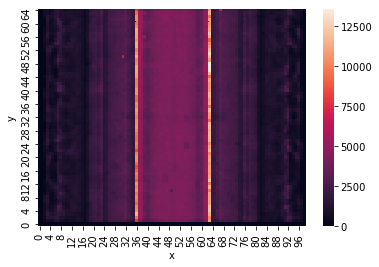

In [35]:
# heatmap of occupancy values for the histogram of interest in run 348251

tmp = pMain_hist20[pMain_hist20['paths']==pMain_hist20['paths'].unique()[13]]
tmp = pd.pivot(tmp,index='y',columns='x',values='occ')
# Reverse the y axis so it can be plotted in standard scale format
tmp = tmp.sort_index(ascending=False)
sns.heatmap(tmp)

<AxesSubplot:xlabel='x', ylabel='y'>

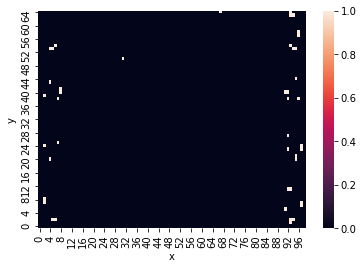

In [36]:
# heatmap of ground truth quality values in the histogram of interest for run 348251

tmp = pMain_hist20[pMain_hist20['paths']==pMain_hist20['paths'].unique()[13]]
tmp = pd.pivot(tmp,index='y',columns='x',values='quality')
# Reverse the y axis so it can be plotted in standard scale format
tmp = tmp.sort_index(ascending=False)
sns.heatmap(tmp)

So, based on the previosuly defined coordinate transormation dictionary, we determined the location of the yellow/red points when we look at the dqm display for this histogram

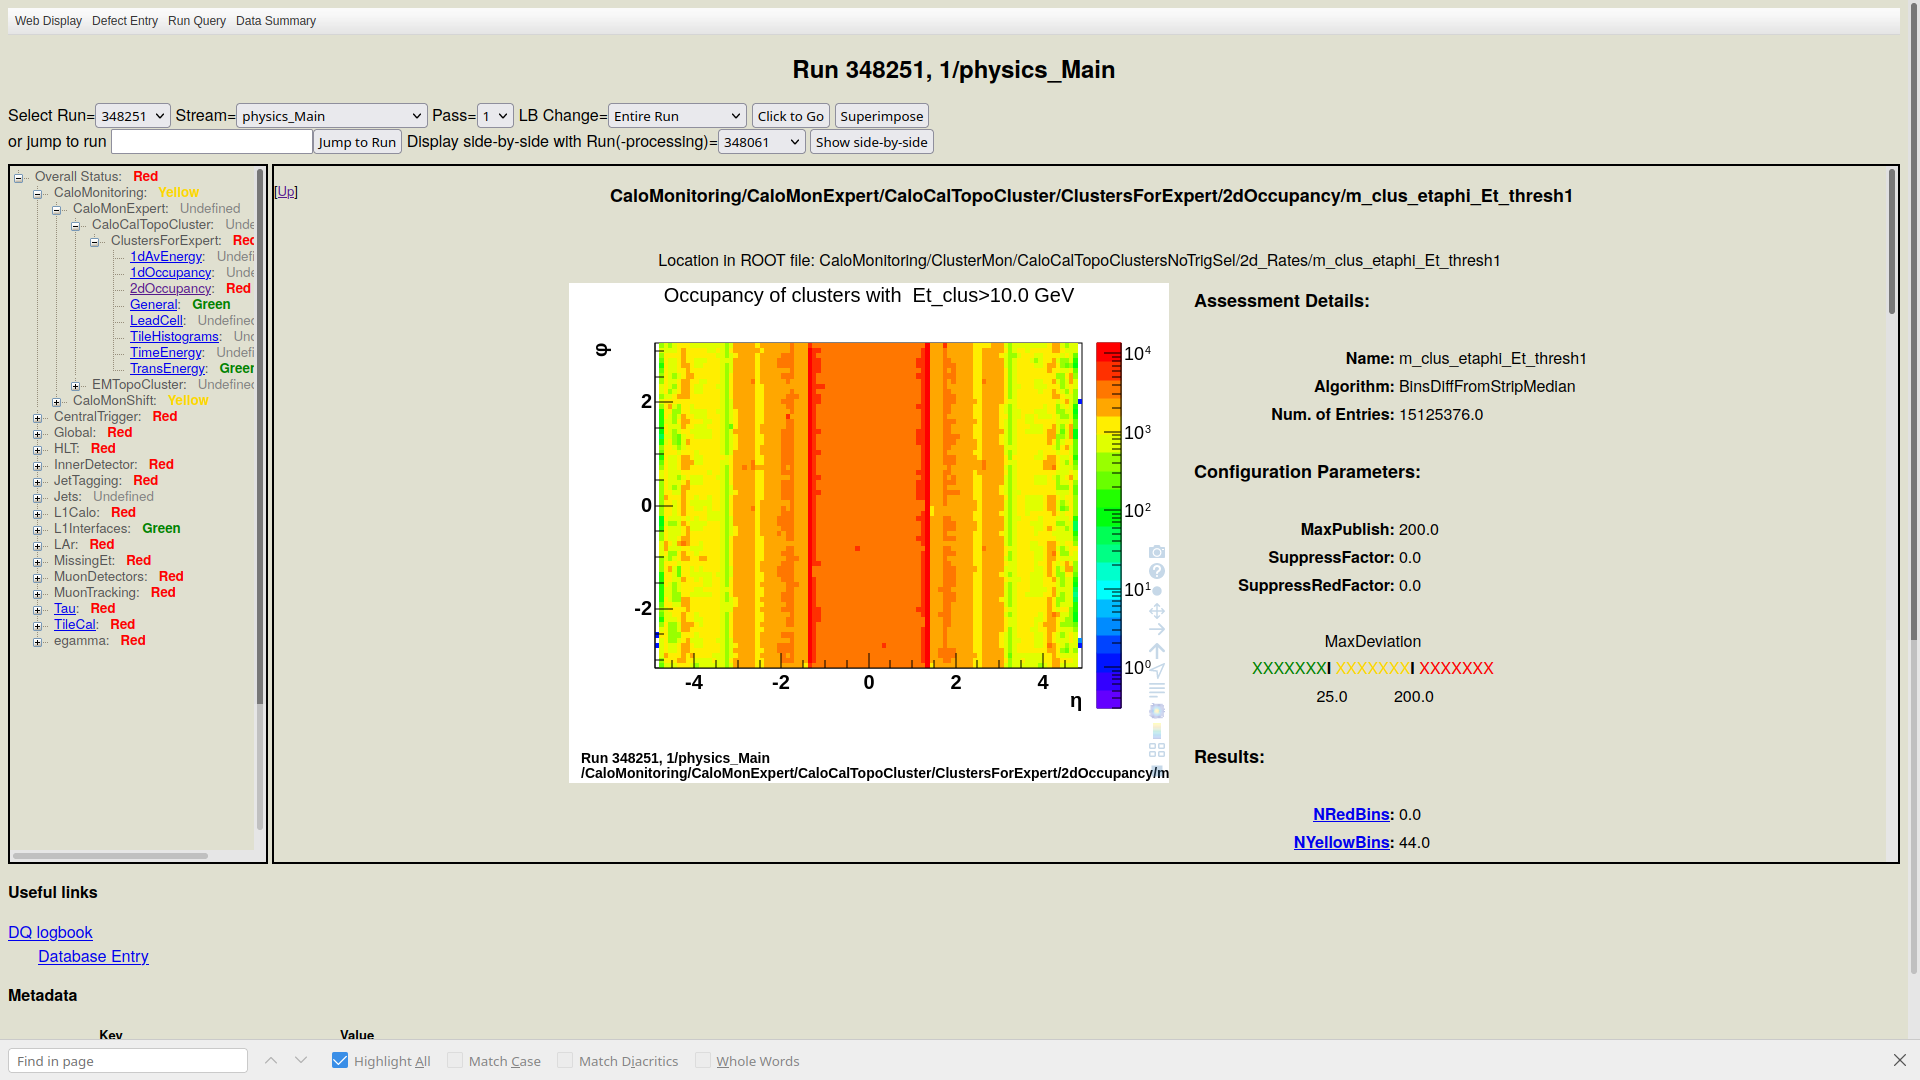

The nredbins, nyellowbins, as well as the coordinate information for those flagged coordinates are identified in the dqm display above. We simply copy and paste these values in a text file to be processed into the dataframe database or collection of dataframes we will use for training/testing

##### The flagged occupancy values for this histogram:
##### IMPORTANT NOTE!: The coordinates in this such as (-1.850,1.723) all seem to be rounded UP to the nearest tenth regardless of value 
- might need to create this as a text file and process it
NRedBins:	0.0
NYellowBins:	44.0
Y0-(eta,phi)[OSRatio]=(-1.850,1.723)[7.59e+01]:	6829.0
Y1-(eta,phi)[OSRatio]=(1.750,3.101)[6.36e+01]:	6491.0
Y10-(eta,phi)[OSRatio]=(4.650,2.412)[3.66e+01]:	2158.0
Y11-(eta,phi)[OSRatio]=(4.350,2.116)[4.24e+01]:	2100.0
Y12-(eta,phi)[OSRatio]=(4.350,-3.002)[4.13e+01]:	2068.0
Y13-(eta,phi)[OSRatio]=(4.650,2.510)[3.30e+01]:	2047.0
Y14-(eta,phi)[OSRatio]=(4.350,3.101)[4.00e+01]:	2029.0
Y15-(eta,phi)[OSRatio]=(4.350,3.002)[3.81e+01]:	1973.0
Y16-(eta,phi)[OSRatio]=(-4.350,2.116)[3.49e+01]:	1938.0
Y17-(eta,phi)[OSRatio]=(4.650,0.541)[2.81e+01]:	1890.0
Y18-(eta,phi)[OSRatio]=(4.350,-3.101)[3.36e+01]:	1842.0
Y19-(eta,phi)[OSRatio]=(4.550,-1.230)[4.05e+01]:	1833.0
Y2-(eta,phi)[OSRatio]=(4.250,-0.935)[3.18e+01]:	3093.0
Y20-(eta,phi)[OSRatio]=(-4.550,-1.230)[3.65e+01]:	1814.0
Y21-(eta,phi)[OSRatio]=(4.350,-2.116)[3.14e+01]:	1777.0
Y22-(eta,phi)[OSRatio]=(-4.550,1.920)[3.41e+01]:	1746.0
Y23-(eta,phi)[OSRatio]=(4.550,1.132)[3.64e+01]:	1724.0
Y24-(eta,phi)[OSRatio]=(4.550,-1.132)[3.62e+01]:	1718.0
Y25-(eta,phi)[OSRatio]=(4.550,2.018)[3.48e+01]:	1680.0
Y26-(eta,phi)[OSRatio]=(-4.350,-3.002)[2.53e+01]:	1653.0
Y27-(eta,phi)[OSRatio]=(-4.550,2.018)[2.63e+01]:	1528.0
Y28-(eta,phi)[OSRatio]=(4.450,-3.002)[3.06e+01]:	1417.0
Y29-(eta,phi)[OSRatio]=(4.450,2.018)[2.96e+01]:	1392.0
Y3-(eta,phi)[OSRatio]=(-4.250,-0.738)[3.01e+01]:	2965.0
Y30-(eta,phi)[OSRatio]=(-4.450,-3.002)[2.78e+01]:	1392.0
Y31-(eta,phi)[OSRatio]=(4.450,3.002)[2.86e+01]:	1366.0
Y32-(eta,phi)[OSRatio]=(-4.450,2.018)[2.66e+01]:	1360.0
Y33-(eta,phi)[OSRatio]=(-4.750,-2.510)[3.52e+01]:	1012.0
Y34-(eta,phi)[OSRatio]=(4.750,-0.837)[3.42e+01]:	942.0
Y35-(eta,phi)[OSRatio]=(4.750,-2.609)[3.28e+01]:	917.0
Y36-(eta,phi)[OSRatio]=(-4.750,-0.837)[2.84e+01]:	883.0
Y37-(eta,phi)[OSRatio]=(-4.750,-2.412)[2.74e+01]:	864.0
Y38-(eta,phi)[OSRatio]=(-4.750,0.640)[2.56e+01]:	832.0
Y39-(eta,phi)[OSRatio]=(4.750,-0.935)[2.74e+01]:	819.0
Y4-(eta,phi)[OSRatio]=(4.250,0.738)[2.79e+01]:	2930.0
Y40-(eta,phi)[OSRatio]=(4.750,-2.510)[2.60e+01]:	794.0
Y41-(eta,phi)[OSRatio]=(4.250,-0.541)[-2.54e+01]:	693.0
Y42-(eta,phi)[OSRatio]=(-4.250,0.541)[-2.62e+01]:	632.0
Y43-(eta,phi)[OSRatio]=(4.250,0.541)[-2.69e+01]:	631.0
Y5-(eta,phi)[OSRatio]=(4.150,-2.707)[3.37e+01]:	2897.0
Y6-(eta,phi)[OSRatio]=(4.250,-2.116)[2.60e+01]:	2851.0
Y7-(eta,phi)[OSRatio]=(4.150,0.738)[2.78e+01]:	2664.0
Y8-(eta,phi)[OSRatio]=(-4.150,0.837)[2.68e+01]:	2577.0
Y9-(eta,phi)[OSRatio]=(-4.150,0.738)[2.65e+01]:	2564.0

Location in ROOT file: CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1 

-END ASIDE- 

In [37]:
express_hist20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90090 entries, 14074 to 20508
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   paths    90090 non-null  object
 1   x        90090 non-null  int64 
 2   y        90090 non-null  int64 
 3   occ      90090 non-null  int64 
 4   quality  90090 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.1+ MB


The memory usage for the fully processed express_hist20 part of the dataset is only 4.1MB
- this is for training on a single type of histogram (TH2, calotopocal/.../mclus_etaphi_Et_thresh1)
- this amounts to only 28 datasets for 28 runs, 70% of that for training, 30% of that for testing, 50% of the original 28 is "good runs" and 50% of the original set is "bad runs"

In [41]:
# UPDATE 8-2-21: Go back and modify this datatype while constructing the dataframe collection. Paths can be made as categories or strings for each dataframe database.
express_hist20[['paths']].astype('string').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90090 entries, 14074 to 20508
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paths   90090 non-null  string
dtypes: string(1)
memory usage: 1.4 MB


### (PREVIOUS ITERATION) IMPORTANT FOR FUTURE ITERATIONS: The assumptions that all datapoints are good (quality=1) or bad (quality=0) is a huge and broad assumption. More careful and detail setting of these quality values is necessary to improve the accuracy of the model!

In [33]:
# These are our taret_set feature Matrices for this hist20 dataset - specifically for the express stream
for idH,hist in enumerate(express_hist20['paths'].unique()):
    print(idH)
    print(hist)
    df_tmp = express_hist20[express_hist20['paths']==hist]
    display(df_tmp.pivot(index='y',columns='x',values='quality'))

0
run_348251/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1
run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2
run_363710/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


3
run_363738/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4
run_363830/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5
run_363910/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


6
run_363947/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


7
run_363979/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


8
run_364030/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


9
run_364076/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


10
run_364098/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


11
run_364160/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


12
run_364214/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


13
run_364292/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# These are our target_set feature Matrices for this hist20 dataset - specifically for the pMain stream
for idH,hist in enumerate(pMain_hist20['paths'].unique()):
    print(idH)
    print(hist)
    df_tmp = pMain_hist20[pMain_hist20['paths']==hist]
    display(df_tmp.pivot(index='y',columns='x',values='quality'))

0
run_348251/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


1
run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


2
run_363710/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


3
run_363738/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


4
run_363830/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


5
run_363910/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


6
run_363947/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


7
run_363979/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


8
run_364030/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


9
run_364076/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


10
run_364098/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


11
run_364160/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


12
run_364214/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


13
run_364292/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1


x,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
y,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
61,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [42]:
def load_hist20_dataset_matrices():
    """
    Assuming express_hist20.csv and pMain_hist20.csv have been constructed from ReplicasProcessingScript.py,  this function will
    load and construct the training and target matrices for the CNN.
    
    IMPORTANT NOTE: We don't actually need to keep track of the runs that we train the model with because its just going to be used for future predictions over histograms whose run
    numbers we WILL know. Therefore, it is not necessary to keep track of this.
    """
    
    # Load the datasets
    express_hist20 = pd.read_csv(record_path+'express_hist20.csv',index_col=[0])
    pMain_hist20 = pd.read_csv(record_path+'pMain_hist20.csv',index_col=[0])
    
    # Initialize the feature_set that will contain our feature variable matrices
    feature_set = []
    
        # Initialize the target_set that will contain our target variable matrices
    target_set = []
    
    # These are our taret_set feature Matrices for this hist20 dataset - specifically for the express stream
    for idH,hist in enumerate(express_hist20['paths'].unique()):
        df_tmp = express_hist20[express_hist20['paths']==hist]
        feature_set.append(df_tmp.pivot(index='y',columns='x',values='occ').to_numpy())
        target_set.append(df_tmp.pivot(index='y',columns='x',values='quality').to_numpy())
    
    # These are our target_set feature Matrices for this hist20 dataset - specifically for the pMain stream
    for idH,hist in enumerate(pMain_hist20['paths'].unique()):
        df_tmp = pMain_hist20[pMain_hist20['paths']==hist]
        feature_set.append(df_tmp.pivot(index='y',columns='x',values='occ').to_numpy())
        target_set.append(df_tmp.pivot(index='y',columns='x',values='quality').to_numpy())
    
    # returns dataset
    return np.stack([np.array(feature_set),np.array(target_set)])

The Dataset comes from this function.

For further clarification. Here,<br>
dataset = load_hist20_dataset_matrices(),<br>
feature_set = load_hist20_dataset_matrices()[0],<br>
target_set = load_hist20_dataset_matrices()[1]

In [43]:
# Dataset shape
load_hist20_dataset_matrices().shape

(2, 28, 65, 99)

In [44]:
def split_hist20(dataset,train_size):
    """
    Takes the dataset that we constructed from the previous assumptions, reads it in as a (2(features,targets),histograms,eta,phi)  shaped tensor,
    randomizes the histograms in the dataset so they arent organized by any sort of run number, then splits them into their respective training and testing sets.
    """
    
    # Initialize the list that will store the random indexes
    ri_list = []

    # Loop through the number of matrices
    for i in range(dataset[0].shape[0]):

        # Get a random index
        ri = np.random.randint(dataset[0].shape[0])

        # While that integer is in the random integer list, keep looking for a random integer that isnt in there
        while ri in ri_list:
            ri = np.random.randint(dataset[0].shape[0])

        # Then append that random integer to the list
        ri_list.append(ri) 

    # Construct the training and testing matrix index list
    train_set_index = ri_list[0:round(train_size*dataset[0].shape[0])]
    test_set_index = ri_list[round(train_size*dataset[0].shape[0]):dataset[0].shape[0]]
    
    # Construct the set of matrixes from the matrix index lists
    train_set = np.stack([np.array([matrix for matrix in dataset[0][train_set_index]]),np.array([matrix for matrix in dataset[1][train_set_index]])])
    test_set = np.stack([np.array([matrix for matrix in dataset[0][test_set_index]]),np.array([matrix for matrix in dataset[1][test_set_index]])])

    return train_set, test_set

In [45]:
# Get handles for the split dataset
train_set,test_set = split_hist20(load_hist20_dataset_matrices(),0.7)

In [46]:
# Make sure everything looks as it should
display(train_set.shape)
display(test_set.shape)
print(round(100*train_set[0].shape[0]/round(load_hist20_dataset_matrices()[0].shape[0])),'%\n')
print(round(100*test_set[0].shape[0]/round(load_hist20_dataset_matrices()[1].shape[0])),'%')

(2, 20, 65, 99)

(2, 8, 65, 99)

71 %

29 %


<b>train_set.shape</b> and <b>test_set.shape</b>
<br>
$\implies$ train_set[occupancy,quality][histogram#][etaValue(x)][phiValue(y)]
<br>
$\implies$ train_set[0][0][0][0] is the occupancy values for the 0th histogram whose coordinates are x=0,y=0
<br>
Same for test_set

##### Save the trainining and testing sets

In [47]:
# Open a file to store the numpy matrix in
with open('train_set.npy', 'wb') as f:
    
    # Save the matrix
    np.save(f, train_set)
    
# Open a file to store the numpy matrix in
with open('test_set.npy', 'wb') as f:
    
    # Save the matrix
    np.save(f, test_set)

##### How to load the training and testing sets

In [ ]:
# NOTE: to read the data back from the files...

# Open the file that train_set is stored in as f
with open('train_set.npy', 'rb') as f:

    # Load and get a handle for train_set
    train_set = np.load(f)

# Open the file that train_set is stored in as f
with open('test_set.npy', 'rb') as f:
    
    # Load and get a handle for test_set
    test_set = np.load(f)

### data processing complete (for phase 1 - testing cnn on a single histogram), see the CNN next actions, return here when/if we test for phase2(possibly multiple histograms)